# 3F8 Binary Classifier #

This notebook is my implementation of the 3F8 coursework. A few of the plotting functions are adapted versions of those provided in the supplementary code.


## The Data ##

We start by importing the required modules as well as the data

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection as sk

In [22]:
X = np.loadtxt('X.txt')
Y = np.loadtxt('Y.txt')

In [23]:
X.shape

(1000, 2)

In [24]:
Y.shape

(1000,)

The data consist of 1000 2D data points, X, and 1000 associated labels, Y.

In [197]:
np.unique(Y)

array([0., 1.])

As expected, the data is binary, i.e. there are two classes.

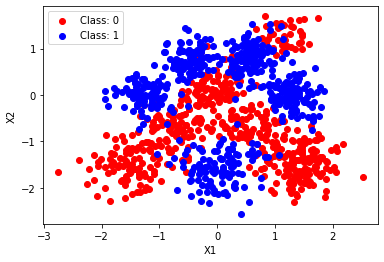

In [45]:
def plot_classes_2D(x, y, c):
    """
        Produces a labelled scatter plot of 2D data
        
        Inputs: X - an (Nx2) array of datapoints
                Y - a length N array of associated labels
                c - a length 2 array of matplotlib colour codes
                
        Outputs: None
    """
    ax = plt.gca()
    for index, label in enumerate(np.unique(y)):
        x1 = [x[i,0] for i in range(x.shape[0]) if y[i] == label]
        x2 = [x[j,1] for j in range(x.shape[0]) if y[j] == label]
        ax.scatter(x1, x2, c=colours[index], label='Class: '+str(int(label)))
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()

colours = ['r', 'b']
plot_classes_2D(X, Y, c)

The data clearly has a very non-linear decision boundary, and so a logistic regression using only the linear input data is unlikely to perform well.

## Training a basic logistic model ##
First we define some useful functions for the training

In [228]:
def logistic(z):
    """
        Sigmoid function
        
        Inputs: z - a numerical input to the function
        Output: sigmoid
    """
    return 1. / (1. + np.exp(-1*z))

def create_X_tilde(x):
    """
        Prepends a column of 1's to the array X
        
        Inputs: x - array of 2D data to form x_tilde
        Output: x_tilde
    """
    ones = np.ones((x.shape[0], 1))
    return np.concatenate((ones, x), axis=1)

def calc_grad(beta, x, y):
    """
    Computes the numerical expression derived elsewhere for the grad of the log-likelihood

    Inputs: beta - current weight values
            x - x_tilde, i.e. data array x with column of 1's prepended
            y - class labels for x
    Output: Grad
    """
    dot_prod = np.matmul(x, beta)
    sigmas = logistic(dot_prod)
    return np.dot(x.T, (np.multiply(y, 1-sigmas) + np.multiply(1-y, sigmas)))

def calc_likelihood(beta, x, y):
     """
        Computes the numerical expression derived elsewhere for the log-likelihood
        
        Inputs: beta - current weight values
                x - x_tilde, i.e. data array x with column of 1's prepended
                y - class labels for x
        Output: log-likelihood
    """
    dot_prod = np.matmul(x, beta)
    sigmas = logistic(dot_prod)
    return np.dot(y.T, sigmas) + np.dot((1-y).T, (1-sigmas).T)

  

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 42)

We use scikitlearn to randomly split the data for testing purposes

In [239]:
X_train, X_test, Y_train, Y_test = sk.train_test_split(X, Y, train_size=0.8)
X_tilde_train = create_X_tilde(X_train)
X_tilde_test = create_X_tilde(X_test)

The basic process for training our beta is gradient ascent. We update beta after each iteration to be it's old value plus the scaled grad at that location

In [246]:
learning_rate = 0.0001
beta = np.random.normal(size=X_tilde.shape[1])
steps = 10000
likelihoods = np.ones(steps)
for i in range(steps):
    beta = beta + learning_rate * calc_grad(beta, X_tilde_train, Y_train)
    likelihood = calc_likelihood(beta, X_tilde_train, Y_train)
    likelihoods[i] = likelihood

The choice of learning_rate and steps have largely been trial and error. If the learning rate is too small then beta never converges, if it is too large then it tends to oscillate.
Additionally if we choose to use too many steps then beta tends to grow unbouded. This is because in each iteration we add a very small term to beta (which will be non-zero when our choice of learning rate is not good enough). A possible improvement to this is to add a regularisation term to the log-likelihood

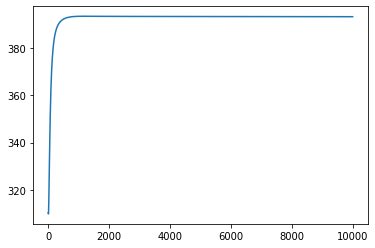

In [247]:
axis = np.arange(steps)
plt.plot(axis, likelihoods)

The log-likelihood converges well.

In [249]:
beta

array([ 407.39806564,   39.73237654, -334.43783177])

In [250]:
def plot_predictive_distribution(x_tilde, y, betas, map_inputs = lambda x : x):
    plot_classes_2D(x_tilde[:,1:], y, colours)
    x_min, x_max = X[ :, 0 ].min() - .5, X[ :, 0 ].max() + .5
    y_min, y_max = X[ :, 1 ].min() - .5, X[ :, 1 ].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    ax = plt.gca()
    new_x_tilde = create_X_tilde(map_inputs(np.concatenate((xx.ravel().reshape((-1, 1)), yy.ravel().reshape((-1, 1))), 1)))
    Z = logistic(np.dot(new_x_tilde, betas))
    Z = Z.reshape(xx.shape)
    cs2 = ax.contour(xx, yy, Z, cmap = 'RdBu', linewidths = 2)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize = 14)
    plt.show()

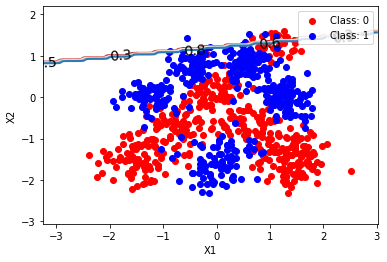

In [251]:
plot_predictive_distribution(X_tilde_train, Y_train, beta)

As expected, the logistic regression performs very poorly...